# Generating Music with RNN

Sources:
- https://www.tensorflow.org/tutorials/audio/music_generation

## Setup

In [ ]:
!sudo apt install -y fluidsynth
%pip install --upgrade pyfluidsynth
%pip install pretty_midi

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from tqdm import tqdm

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [ ]:
import os
import urllib.request
import zipfile
from pathlib import Path

# Define the directory where data will be stored
data_dir = Path('data/maestro-v2.0.0')

# Check if the data directory already exists
if not data_dir.exists():
    os.makedirs(data_dir)

    # URL of the file to be downloaded
    url = 'https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip'

    # Define the local path where the zip file will be saved
    zip_path = Path('data/maestro-v2.0.0-midi.zip')

    # Download the file from the given URL
    print(f'Downloading {url}...')
    urllib.request.urlretrieve(url, zip_path)

    # Extract the contents of the zip file
    print('Extracting files...')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data/')

    # Remove the zip file after extraction
    os.remove(zip_path)

Extracting files...


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## MIDI Processing

In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [ ]:
from google.colab import files
sample_file = filenames[1]
print(sample_file)
# files.download(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

data/maestro-v2.0.0/2009/MIDI-Unprocessed_07_R2_2009_01_ORIG_MID--AUDIO_07_R2_2009_07_R2_2009_03_WAV.midi


In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
print('Program:', instrument.program)
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

Number of instruments: 1
Program: 0
Instrument name: Acoustic Grand Piano
0: pitch=63, note_name=D#4, duration=0.1966
1: pitch=55, note_name=G3, duration=0.0807
2: pitch=48, note_name=C3, duration=0.4089
3: pitch=65, note_name=F4, duration=0.0807
4: pitch=50, note_name=D3, duration=0.0690
5: pitch=77, note_name=F5, duration=0.1237
6: pitch=75, note_name=D#5, duration=0.5430
7: pitch=55, note_name=G3, duration=0.0625
8: pitch=67, note_name=G4, duration=0.0651
9: pitch=79, note_name=G5, duration=0.1120


In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     75  1.014323  1.557292  0.000000  0.542969
1     63  1.015625  1.212240  0.001302  0.196615
2     48  1.037760  1.446615  0.022135  0.408854
3     55  1.234375  1.315104  0.196615  0.080729
4     65  1.412760  1.493490  0.178385  0.080729

In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['D#5', 'D#4', 'C3', 'G3', 'F4', 'F5', 'D3', 'G3', 'G5', 'G4'],
      dtype='<U3')

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [ ]:
a = np.stack([raw_notes['pitch'], raw_notes['pitch']], axis=0)
print(a)
a = np.stack([raw_notes['start'], raw_notes['end']], axis=0)
print(a)

[[75 63 48 ... 36 51 43]
 [75 63 48 ... 36 51 43]]
[[  1.01432292   1.015625     1.03776042 ... 166.20703125 166.21223958
  166.2421875 ]
 [  1.55729167   1.21223958   1.44661458 ... 166.52734375 166.62109375
  166.53515625]]


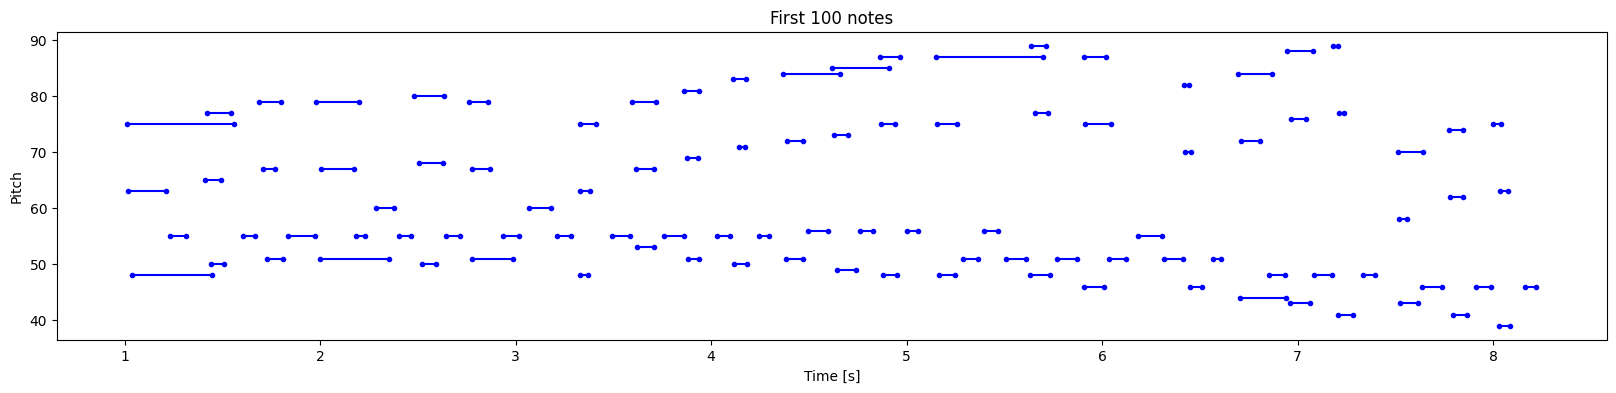

In [ ]:
plot_piano_roll(raw_notes, 100)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

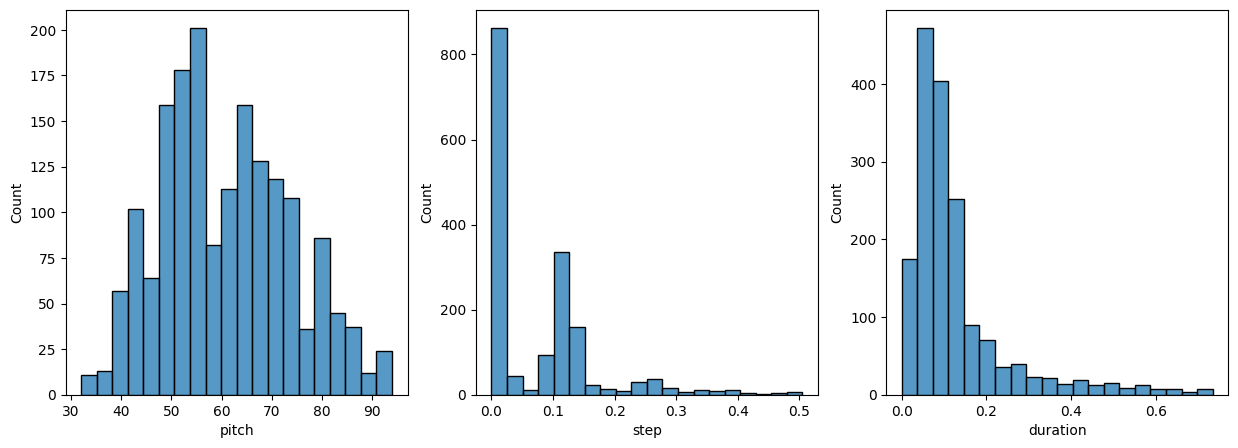

In [ ]:
plot_distributions(raw_notes)

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [ ]:
display_audio(example_pm)

### Playing Around

In [ ]:
# Print an empirical estimate of its global tempo
print(pm.estimate_tempo())

# Compute the relative amount of each semitone across the entire song,
# a proxy for key
total_velocity = sum(sum(pm.get_chroma()))
print([sum(semitone)/total_velocity for semitone in pm.get_chroma()])

# Shift all notes up by 5 semitones
for instrument in pm.instruments:
    # Don't want to shift drum notes
    if not instrument.is_drum:
        for note in instrument.notes:
            note.pitch += 5

# Synthesize the resulting MIDI data using sine waves
# audio_data = pm.synthesize()

display_audio(pm)

224.09009470181905
[0.1338017368890838, 0.06376586503762408, 0.03503946038188421, 0.2296605660528385, 0.017805770034055726, 0.05091374679571475, 0.017449607548626775, 0.19150611328186745, 0.10523340245822742, 0.011131507028071254, 0.12363109503652768, 0.020061129455478343]


In [ ]:
# Create a PrettyMIDI object
cello_c_chord = pretty_midi.PrettyMIDI()

# Create an Instrument instance for a cello instrument
cello_program = pretty_midi.instrument_name_to_program('Cello')
print('Program:', cello_program)
cello = pretty_midi.Instrument(program=cello_program)

# Iterate over note names, which will be converted to note number later
for note_name in ['C2', 'E2', 'G2']:
    # Retrieve the MIDI note number for this note name
    note_number = pretty_midi.note_name_to_number(note_name)

    # Create a Note instance, starting at 0s and ending at 1.5s
    note = pretty_midi.Note(
        velocity=100, pitch=note_number, start=0, end=2)

    # Add it to our cello instrument
    cello.notes.append(note)

# Add the cello instrument to the PrettyMIDI object
cello_c_chord.instruments.append(cello)

# Write out the MIDI data
# cello_c_chord.write('cello-C-chord.mid')

display_audio(cello_c_chord)

Program: 42


In [ ]:
# Create a PrettyMIDI object
drums = pretty_midi.PrettyMIDI()
drum = pretty_midi.Instrument(program=9, is_drum=True)
print(drum.is_drum)

# hits per quarter note
hpq = 3

for i in range(32):
    note_number = pretty_midi.note_name_to_number('B1')
    note = pretty_midi.Note(
        velocity=100, pitch=note_number, start=i/(2**hpq), end=i/(2**hpq))
    drum.notes.append(note)

hpq = 2
for i in range(8):
    note_number = pretty_midi.note_name_to_number('D2')
    note = pretty_midi.Note(
        velocity=100, pitch=note_number, start=i/(2**hpq), end=i/(2**hpq))
    drum.notes.append(note)

hpq = 1
for i in range(4):
    note_number = pretty_midi.note_name_to_number('A3')
    note = pretty_midi.Note(
        velocity=100, pitch=note_number, start=i+1, end=i+1)
    drum.notes.append(note)


drums.instruments.append(drum)
display_audio(drums)

True


## Data Processing

In [ ]:
def get_midi_data(filenames, num_files):
    all_notes = []
    file_id = 0
    for f in filenames[:num_files]:
        notes = midi_to_notes(f)
        notes['file_id'] = file_id
        all_notes.append(notes)
        file_id += 1

    return all_notes

In [ ]:
num_files = 5
all_notes = get_midi_data(filenames, num_files)

all_notes_cat = pd.concat(all_notes)

n_notes = len(all_notes_cat)
print('Number of notes parsed:', n_notes)

all_notes_cat.head(26)

Number of notes parsed: 17824


pitch     start       end      step  duration  file_id
0      63  1.028646  1.121094  0.000000  0.092448        0
1      75  1.028646  1.229167  0.000000  0.200521        0
2      48  1.045573  1.113281  0.016927  0.067708        0
3      55  1.170573  1.264323  0.125000  0.093750        0
4      77  1.283854  1.580729  0.113281  0.296875        0
5      65  1.296875  1.351562  0.013021  0.054688        0
6      50  1.299479  1.567708  0.002604  0.268229        0
7      55  1.419271  1.490885  0.119792  0.071615        0
8      79  1.539062  1.619792  0.119792  0.080729        0
9      51  1.544271  1.618490  0.005208  0.074219        0
10     67  1.562500  1.606771  0.018229  0.044271        0
11     55  1.667969  1.759115  0.105469  0.091146        0
12     51  1.820312  1.932292  0.152344  0.111979        0
13     79  1.830729  2.390625  0.010417  0.559896        0
14     67  1.838542  2.095052  0.007812  0.256510        0
15     55  1.944010  2.048177  0.105469  0.104167        0
16     60  2.089844  2.389323  0.145833  0.299479        0
17     55  2.220052  2.345052  0.130208  0.125000        0
18     80  2.371094  2.430990  0.151042  0.059896        0
19     68  2.372396  2.417969  0.001302  0.045573        0
20     50  2.377604  2.511719  0.005208  0.134115        0
21     55  2.533854  2.654948  0.156250  0.121094        0
22     79  2.648438  2.851562  0.114583  0.203125        0
23     67  2.657552  2.888021  0.009115  0.230469        0
24     51  2.682292  2.826823  0.024740  0.144531        0
25     55  2.824219  2.934896  0.141927  0.110677        0

In [ ]:
# Cell not used
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes_cat[key] for key in key_order], axis=1)
# Alternative method: train_notes = np.array(all_notes_cat[key_order])
print(train_notes)

[[6.30000000e+01 0.00000000e+00 9.24479167e-02]
 [7.50000000e+01 0.00000000e+00 2.00520833e-01]
 [4.80000000e+01 1.69270833e-02 6.77083333e-02]
 ...
 [4.70000000e+01 1.36718750e-01 3.38541667e-02]
 [4.30000000e+01 2.21354167e-01 5.09375000e+00]
 [3.10000000e+01 4.67447917e-01 4.57421875e+00]]


## Train/Val/Test Sets

In [ ]:
seq_length = 25
vocab_size = 128
take_last = True

In [ ]:
from torch.utils.data import Dataset, random_split, DataLoader

class MidiSequenceDataset(Dataset):
    def __init__(self, all_notes, seq_length, vocab_size=128, take_last=True):
        self.seq_length = seq_length + 1  # Include 1 extra for labels
        self.vocab_size = vocab_size
        self.sequences = self.create_sequences(all_notes)

    def create_sequences(self, all_notes):
        sequences = []
        key_order = ['pitch', 'step', 'duration']
        for notes in all_notes:
            notes = notes[key_order]
            for i in range(len(notes) - self.seq_length + 1):
                seq = torch.tensor(notes[i:i + self.seq_length].values, dtype=torch.float32)
                sequences.append(seq)
        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        input = sequence[:-1].clone()
        input[:, 0] /= self.vocab_size
        targets = {
            'pitch': sequence[1:, 0].to(torch.long),
            'step': sequence[1:, 1],
            'duration': sequence[1:, 2]
        }
        if take_last:
            for key in targets:
                targets[key] = targets[key][-1]
        return input, targets

In [ ]:
midi_ds = MidiSequenceDataset(all_notes, seq_length, vocab_size, take_last)
print(len(midi_ds))

17699


In [ ]:
midi_iter = iter(midi_ds)
seq, target = next(midi_iter)
print('sequence shape:', seq.shape)
print('sequence elements (first 10):', seq[0: 10])
print()
print('target:', target)

sequence shape: torch.Size([25, 3])
sequence elements (first 10): tensor([[0.4922, 0.0000, 0.0924],
        [0.5859, 0.0000, 0.2005],
        [0.3750, 0.0169, 0.0677],
        [0.4297, 0.1250, 0.0938],
        [0.6016, 0.1133, 0.2969],
        [0.5078, 0.0130, 0.0547],
        [0.3906, 0.0026, 0.2682],
        [0.4297, 0.1198, 0.0716],
        [0.6172, 0.1198, 0.0807],
        [0.3984, 0.0052, 0.0742]])

target: {'pitch': tensor(55), 'step': tensor(0.1419), 'duration': tensor(0.1107)}


In [ ]:
# Define the split sizes (e.g., 80% training, 20% validation)
training_ratio = 0.8
batch_size = 64

train_size = int(training_ratio * len(midi_ds))
val_size = len(midi_ds) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(midi_ds, [train_size, val_size])

# Create DataLoaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(len(train_loader))
print(len(val_loader))

222
56


## RNN Model

In [ ]:
class MidiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_state_dim, layer_dim, dropout, out_dims, take_last=True):
        super().__init__()
        self.hidden_state_dim = hidden_state_dim
        self.layer_dim = layer_dim
        self.take_last = take_last

        self.lstm = nn.LSTM(input_dim, hidden_state_dim, layer_dim, batch_first=True, dropout=dropout)
        self.fc_pitch = nn.Linear(hidden_state_dim, out_dims['pitch'])
        self.fc_step = nn.Linear(hidden_state_dim, out_dims['step'])
        self.fc_duration = nn.Linear(hidden_state_dim, out_dims['duration'])

    def forward(self, x):
        batch_dim, seq_dim, _ = x.size()
        h0 = torch.zeros(self.layer_dim, batch_dim, self.hidden_state_dim).to(device)
        c0 = torch.zeros(self.layer_dim, batch_dim, self.hidden_state_dim).to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0)) # (N, L, H)
        out_pitch = self.fc_pitch(out) # (N, L, 128)
        out_step = self.fc_step(out) # (N, L, 1)
        out_duration = self.fc_duration(out) # (N, L, 2)
        outputs = {'pitch': out_pitch, 'step': out_step, 'duration': out_duration}
        if self.take_last:
            for key in outputs:
                outputs[key] = outputs[key][:, -1]
        return outputs

In [ ]:
input_dim = seq.shape[1]
out_dims = {
    'pitch': 128,
    'step': 1,
    'duration': 1
}
hidden_state_dim = 128
layer_dim = 1
dropout = 0
vocab_size = 128

model = MidiLSTM(input_dim, hidden_state_dim, layer_dim, dropout, out_dims, take_last)
model.to(device)

MidiLSTM(
  (lstm): LSTM(3, 128, batch_first=True)
  (fc_pitch): Linear(in_features=128, out_features=128, bias=True)
  (fc_step): Linear(in_features=128, out_features=1, bias=True)
  (fc_duration): Linear(in_features=128, out_features=1, bias=True)
)

## Training

In [ ]:
def mse_with_positive_pressure(outputs, targets):
    mse = (targets - outputs) ** 2
    positive_pressure = 10 * torch.maximum(-outputs, torch.tensor(0.0))
    return torch.mean(mse + positive_pressure)

class MidiLoss(nn.Module):
    def __init__(self, w_loss):
        super().__init__()
        self.w_loss = w_loss
        self.loss_fns = {
            'pitch': nn.CrossEntropyLoss(),
            'step': mse_with_positive_pressure,
            'duration': mse_with_positive_pressure
        }

    def forward(self, outputs, targets):
        pitch_loss = self.loss_fns['pitch'](outputs['pitch'], targets['pitch'])
        step_loss = self.loss_fns['step'](outputs['step'], targets['step'])
        duration_loss = self.loss_fns['duration'](outputs['duration'], targets['duration'])
        loss = self.w_loss['pitch'] * pitch_loss + \
               self.w_loss['step'] * step_loss + \
               self.w_loss['duration'] * duration_loss
        return loss, [pitch_loss, step_loss, duration_loss]

In [ ]:
import torch.optim as optim

learning_rate = 5e-3
n_epochs = 3
loss_weights = {
    'pitch': 0.05,
    'step': 1.0,
    'duration': 1.0
}

criterion = MidiLoss(loss_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Test on one example
inputs, targets = next(iter(train_loader))
print(inputs.shape)
print(targets)
outputs = model(inputs.to(device))
print(outputs['pitch'].shape, outputs['step'].shape, outputs['duration'].shape)

targets = {key: target.to(device) for key, target in targets.items()}
criterion(outputs, targets)

torch.Size([64, 25, 3])
{'pitch': tensor([72, 75, 73, 66, 82, 96, 80, 67, 55, 59, 56, 89, 68, 77, 67, 77, 83, 63,
        55, 62, 67, 59, 56, 70, 67, 70, 63, 60, 51, 77, 60, 73, 68, 79, 56, 51,
        64, 67, 51, 79, 84, 65, 55, 50, 99, 53, 78, 73, 43, 51, 45, 59, 88, 47,
        89, 33, 79, 72, 84, 55, 67, 70, 55, 49]), 'step': tensor([1.8229e-02, 4.1667e-01, 1.6927e-02, 6.5104e-03, 0.0000e+00, 9.5052e-02,
        3.9062e-03, 2.4479e-01, 3.9062e-03, 9.1146e-03, 9.1927e-01, 2.8646e-02,
        2.9948e-02, 1.2721e+00, 2.0052e-01, 4.1667e-02, 2.6042e-03, 1.9531e-02,
        1.4193e-01, 9.1146e-03, 1.2891e-01, 2.2135e-02, 1.3281e-01, 5.2083e-03,
        8.0729e-02, 1.0938e-01, 1.1068e-01, 0.0000e+00, 1.3021e-03, 7.8125e-03,
        6.5104e-03, 8.2031e-02, 6.5104e-03, 1.3125e+00, 3.9062e-03, 4.5573e-02,
        1.1849e-01, 1.1589e-01, 9.5052e-02, 2.0833e-02, 1.0938e-01, 6.6406e-02,
        2.3568e-01, 1.4714e-01, 6.3802e-02, 3.9062e-03, 2.3568e-01, 1.0938e-01,
        1.9531e-02, 2.6042e-

(tensor(0.3245, grad_fn=<AddBackward0>),
 [tensor(3.9336, grad_fn=<NllLossBackward0>),
  tensor(0.0612, grad_fn=<MeanBackward0>),
  tensor(0.0666, grad_fn=<MeanBackward0>)])

In [ ]:
# Create directories for saving checkpoints
checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

print_progess = 100

# Early stopping parameters
patience = 5
best_loss = float('inf')
patience_counter = 0

# History tracking
losses = {'training': [], 'val': []}

In [ ]:
for epoch in range(n_epochs):
    running_loss = 0.0
    epoch_loss = 0.0
    df_loss = pd.DataFrame(columns=['pitch_loss', 'step_loss', 'duration_loss'])
    for i, data in enumerate(train_loader):
        inputs, targets = data
        inputs = inputs.to(device)
        targets = {key: target.to(device) for key, target in targets.items()}

        optimizer.zero_grad()
        outputs = model(inputs)
        loss, details = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        details = [l.item() for l in details]
        df_loss.loc[len(df_loss)] = details

        if i % print_progess == 99:
            loss_details_str = ', '.join([f'{col}: {mean:.3f}' for col, mean in df_loss.mean().items()])
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_progess:.3f}, {loss_details_str}')
            running_loss = 0.0
            df_loss.drop(df_loss.index, inplace=True)

    val_loss = 0.0
    df_val_loss = pd.DataFrame(columns=['pitch_loss', 'step_loss', 'duration_loss'])
    for _, data in enumerate(val_loader):
        with torch.no_grad():
            inputs, targets = data
            inputs = inputs.to(device)
            targets = {key: target.to(device) for key, target in targets.items()}

            outputs = model(inputs)
            loss, details = criterion(outputs, targets)

            val_loss += loss.item()
            details = [l.item() for l in details]
            df_val_loss.loc[len(df_val_loss)] = details

    avg_training_loss = epoch_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    losses['training'].append(avg_training_loss)
    losses['val'].append(avg_val_loss)

    val_loss_details_str = ', '.join([f'{col}: {mean:.3f}' for col, mean in df_val_loss.mean().items()])
    print(f'epoch: {epoch + 1}, training_loss: {avg_training_loss:.3f}, val_loss: {avg_val_loss:.3f}, {val_loss_details_str}')

    # Save checkpoint
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0

        # Save checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'ckpt_epoch_{epoch}.pth')
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")
    else:
        # Early stopping
        patience_counter += 1
        print(f"Early stopping patience counter: {patience_counter}/{patience}")

        # Early stopping trigger
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print('Finished Training')


[1,   100] loss: 0.438, pitch_loss: 3.682, step_loss: 0.055, duration_loss: 0.199
[1,   200] loss: 0.399, pitch_loss: 3.685, step_loss: 0.044, duration_loss: 0.171
epoch: 1, training_loss: 0.412, val_loss: 0.384, pitch_loss: 3.721, step_loss: 0.047, duration_loss: 0.151
Checkpoint saved at ./training_checkpoints/ckpt_epoch_0.pth
[2,   100] loss: 0.439, pitch_loss: 3.642, step_loss: 0.052, duration_loss: 0.205
[2,   200] loss: 0.369, pitch_loss: 3.616, step_loss: 0.048, duration_loss: 0.140
epoch: 2, training_loss: 0.408, val_loss: 0.385, pitch_loss: 3.728, step_loss: 0.047, duration_loss: 0.152
Early stopping patience counter: 1/5
[3,   100] loss: 0.409, pitch_loss: 3.599, step_loss: 0.049, duration_loss: 0.180
[3,   200] loss: 0.389, pitch_loss: 3.593, step_loss: 0.045, duration_loss: 0.164
epoch: 3, training_loss: 0.407, val_loss: 0.383, pitch_loss: 3.690, step_loss: 0.047, duration_loss: 0.151
Checkpoint saved at ./training_checkpoints/ckpt_epoch_2.pth
Finished Training


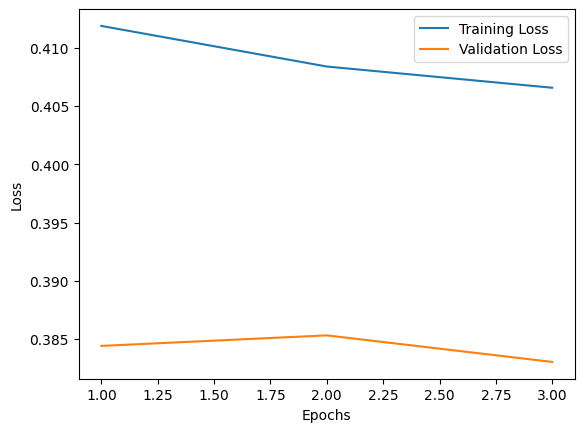

In [ ]:
# Plot the training history
plt.plot(range(1, len(losses['training']) + 1), losses['training'], label='Training Loss')
plt.plot(range(1, len(losses['val']) + 1), losses['val'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Generation

In [ ]:
def predict_next_note(notes, model, temperature=1.0):
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

    assert temperature > 0

    # Add batch
    inputs = notes[None, :]

    model.eval()
    with torch.no_grad():
        preds = model(inputs)
        pitch_logits = preds['pitch'].squeeze(-1)
        step = preds['step'].squeeze(-1)
        duration = preds['duration'].squeeze(-1)

        pitch_logits /= temperature
        pitch = torch.multinomial(F.softmax(pitch_logits, dim=-1), num_samples=1)
        step = torch.maximum(torch.tensor(0.0), step)
        duration = torch.maximum(torch.tensor(0.0), duration)

    return int(pitch), float(step), float(duration)

In [ ]:
temperature = 2.0
num_predictions = 120

sample_notes = np.array(raw_notes[key_order])

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(torch.tensor(input_notes, dtype=torch.float32).to(device), model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes.head(10)

pitch      step  duration     start       end
0     79  0.115190  0.217305  0.115190  0.332495
1     69  0.090352  0.340048  0.205542  0.545590
2     83  0.091485  0.380886  0.297027  0.677913
3     95  0.095434  0.384948  0.392461  0.777409
4     74  0.096521  0.385397  0.488982  0.874378
5     73  0.096280  0.388799  0.585262  0.974061
6     74  0.096191  0.390084  0.681452  1.071536
7     85  0.096091  0.389511  0.777544  1.167055
8     68  0.095850  0.389797  0.873394  1.263191
9     71  0.096492  0.389861  0.969885  1.359746

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

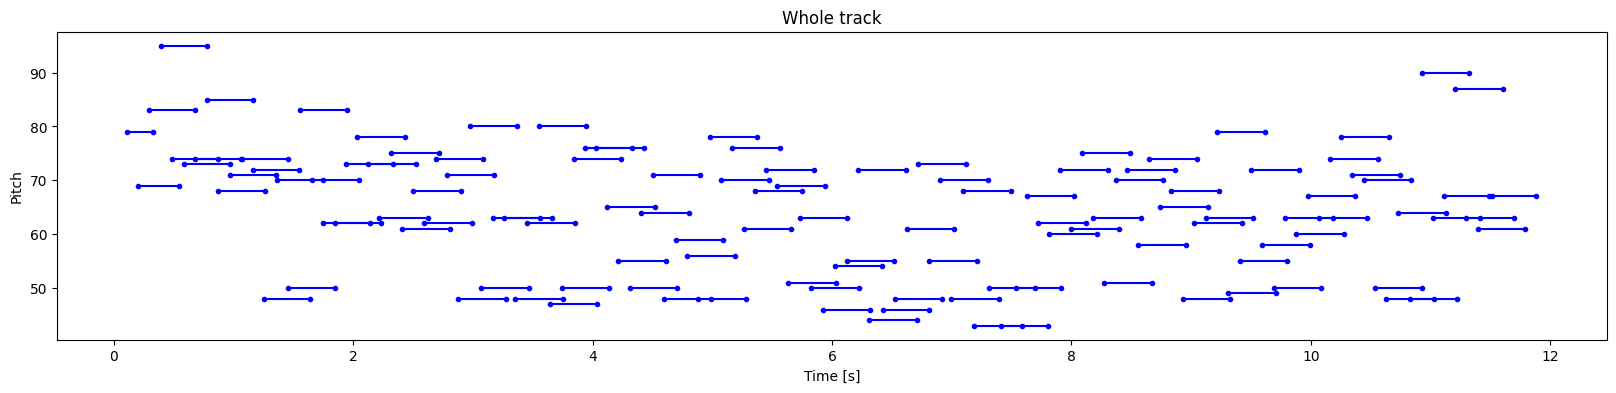

In [ ]:
plot_piano_roll(generated_notes)

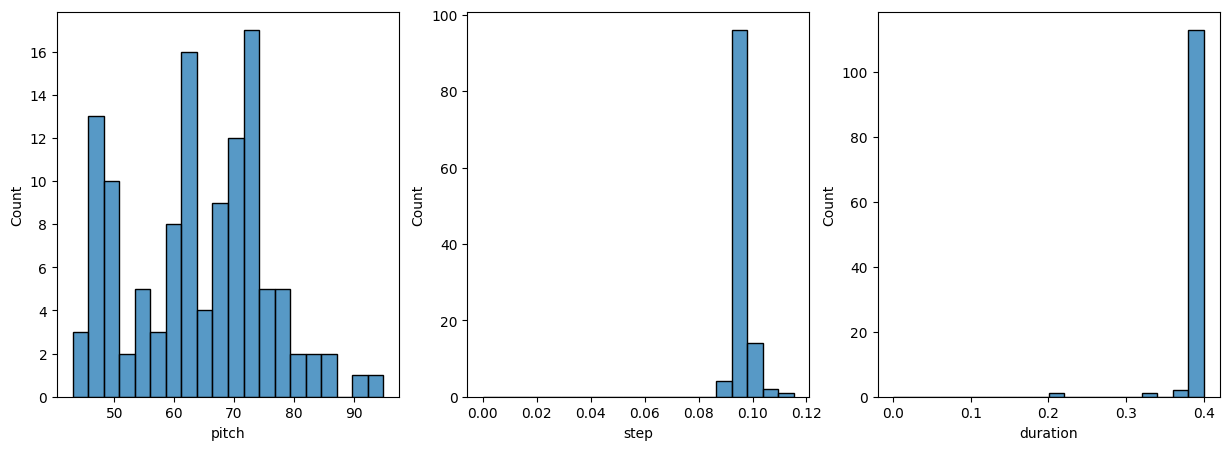

In [ ]:
plot_distributions(generated_notes)

## Todo

Training/Tuning
- Increase number of files used
- Increase number of epochs
- Hyperparameter tuning (learning_rate, batch_size, hidden_dim, layers, dropout)

Formulation
- Try one_hot encoded pitch
- Try ReLU on the output of the timing variables (always > 0)
- Try normalizing the timing variables (hopefully bring the losses within the same range)
- Try using all output layer loss instead of last prediction
- Ratio of teacher forcing
- Add accuracy measurement
- Layer/Batch norm
- Data augmentation
- Tokenization

Refactoring
- Clean up the generation code
- Ability to load a model checkpoint
- Print model size